In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from minisom import MiniSom

sns.set_style("whitegrid")

try:
    df = pd.read_csv('creditcard.csv')
    print("✅ Base de dados carregada com sucesso!")
    print(f"Dimensões originais: {df.shape}")
except FileNotFoundError:
    print("❌ ERRO: O arquivo 'creditcard.csv' não foi encontrado.")

✅ Base de dados carregada com sucesso!
Dimensões originais: (284807, 31)



=== QUESTÃO 1: PRÉ-PROCESSAMENTO ===

--- 1. Visualização da Distribuição ---
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


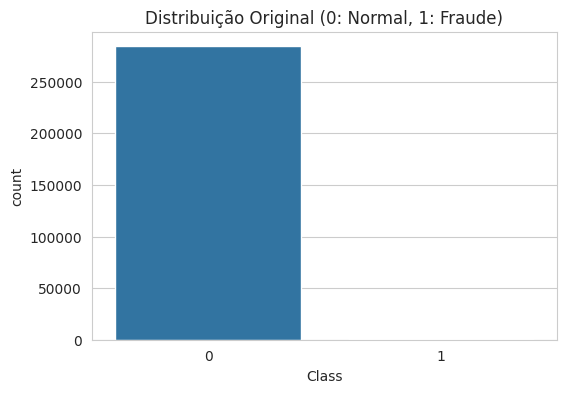


--- 2. Verificação de Nulos ---
Total de nulos encontrados: 0

--- 3. Verificação de Duplicatas ---
Duplicatas encontradas: 1081
Duplicatas removidas.


In [19]:
print("\n=== QUESTÃO 1: PRÉ-PROCESSAMENTO ===")

print("\n--- 1. Visualização da Distribuição ---")
print(df['Class'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Distribuição Original (0: Normal, 1: Fraude)")
plt.show()

print("\n--- 2. Verificação de Nulos ---")
nulos = df.isnull().sum().max()
print(f"Total de nulos encontrados: {nulos}")

df.dropna(subset=['Class'], inplace=True)

print("\n--- 3. Verificação de Duplicatas ---")
duplicatas = df.duplicated().sum()
print(f"Duplicatas encontradas: {duplicatas}")
if duplicatas > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicatas removidas.")


--- 4. Tratamento de Outliers e 5. Normalização ---


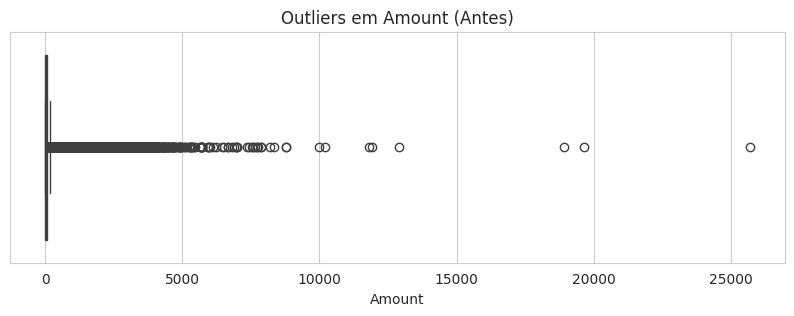

Variáveis Amount e Time normalizadas.

--- 6. Matriz de Correlação ---


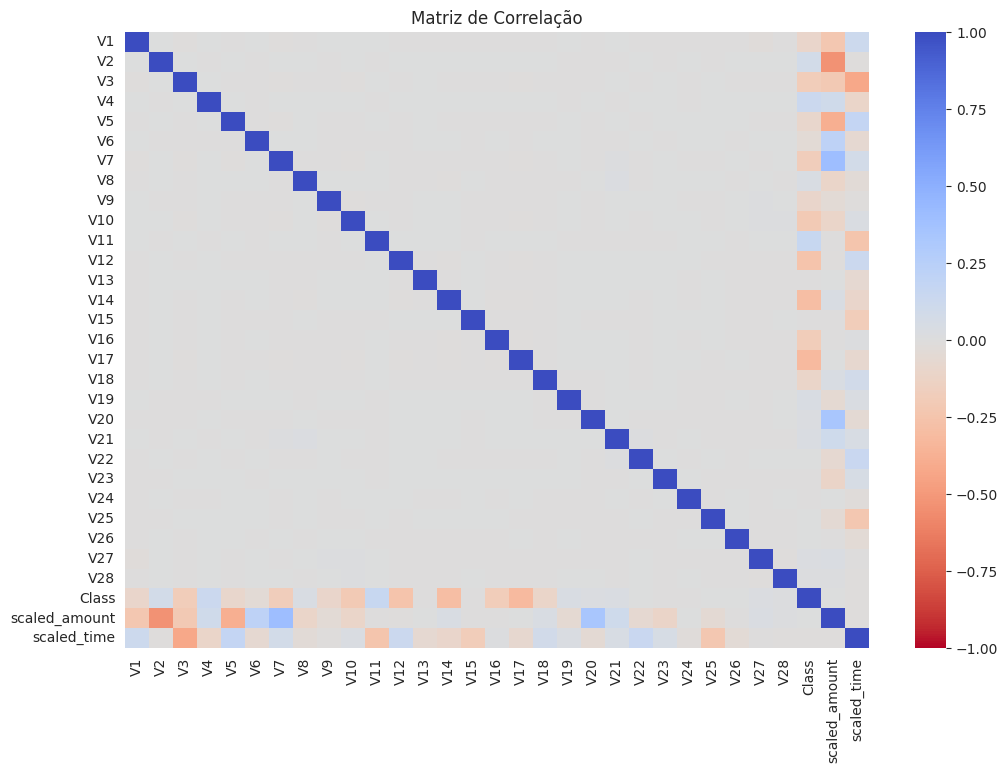

In [20]:
print("\n--- 4. Tratamento de Outliers e 5. Normalização ---")

plt.figure(figsize=(10,3))
sns.boxplot(x=df['Amount'])
plt.title("Outliers em Amount (Antes)")
plt.show()

rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)
print("Variáveis Amount e Time normalizadas.")

print("\n--- 6. Matriz de Correlação ---")
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm_r', vmin=-1, vmax=1)
plt.title("Matriz de Correlação")
plt.show()

In [21]:
print("\n--- 8 e 9. Divisão e Balanceamento (SMOTE) ---")

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Aplicando SMOTE...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Treino Original: {y_train.value_counts().to_dict()}")
print(f"Treino Balanceado: {y_train_res.value_counts().to_dict()}")

print("\n--- RELATÓRIO: Comparação de Performance ---")

lr_raw = LogisticRegression(max_iter=1000)
lr_raw.fit(X_train, y_train)
pred_raw = lr_raw.predict(X_test)
print("\n>> ANTES DO BALANCEAMENTO (Recall baixo para Fraude):")
print(classification_report(y_test, pred_raw))

lr_bal = LogisticRegression(max_iter=1000)
lr_bal.fit(X_train_res, y_train_res)
pred_bal = lr_bal.predict(X_test)
print("\n>> DEPOIS DO PRÉ-PROCESSAMENTO (Recall melhorado):")
print(classification_report(y_test, pred_bal))


--- 8 e 9. Divisão e Balanceamento (SMOTE) ---
Aplicando SMOTE...
Treino Original: {0: 226602, 1: 378}
Treino Balanceado: {0: 226602, 1: 226602}

--- RELATÓRIO: Comparação de Performance ---

>> ANTES DO BALANCEAMENTO (Recall baixo para Fraude):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.85      0.58      0.69        95

    accuracy                           1.00     56746
   macro avg       0.92      0.79      0.84     56746
weighted avg       1.00      1.00      1.00     56746


>> DEPOIS DO PRÉ-PROCESSAMENTO (Recall melhorado):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746



In [22]:
print("\n\n=== QUESTÃO 2: ALGORITMOS DE AGRUPAMENTO ===")
print("(Removendo a classe e usando amostragem para viabilizar o cálculo)")

X_full_cluster = df.drop('Class', axis=1)

X_cluster = X_full_cluster.sample(frac=0.10, random_state=42)
print(f"Tamanho da amostra: {X_cluster.shape}")



=== QUESTÃO 2: ALGORITMOS DE AGRUPAMENTO ===
(Removendo a classe e usando amostragem para viabilizar o cálculo)
Tamanho da amostra: (28373, 30)



--- 1. K-Means (K=2) ---
Silhouette Score K-Means: 0.6304

--- 2. DBSCAN ---
Clusters encontrados: 17
Pontos considerados ruído: 8665
Silhouette Score DBSCAN: -0.0751
Treinando SOM...
Erro de Quantização SOM: 3.4614


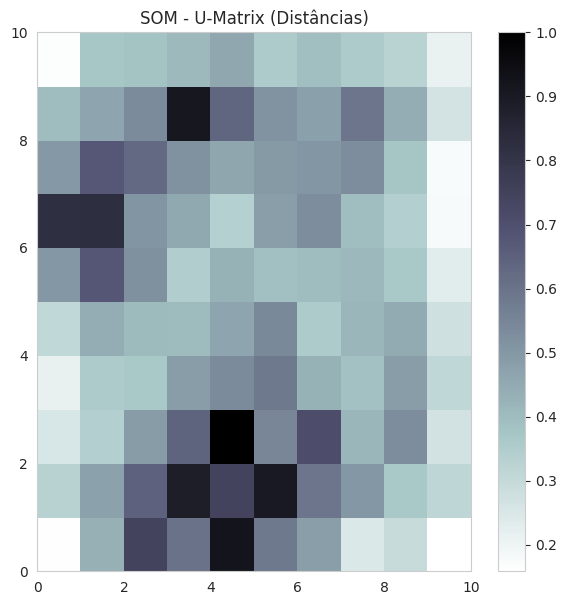

In [23]:
print("\n--- 1. K-Means (K=2) ---")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_cluster)
sil_kmeans = silhouette_score(X_cluster, labels_kmeans)
print(f"Silhouette Score K-Means: {sil_kmeans:.4f}")

print("\n--- 2. DBSCAN ---")
dbscan = DBSCAN(eps=2.5, min_samples=20)
labels_dbscan = dbscan.fit_predict(X_cluster)

n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)
print(f"Clusters encontrados: {n_clusters}")
print(f"Pontos considerados ruído: {n_noise}")

if n_clusters > 1:
    print(f"Silhouette Score DBSCAN: {silhouette_score(X_cluster, labels_dbscan):.4f}")
else:
    print("Silhouette Score: Não calculado (apenas 1 cluster ou ruído encontrados).")

    print("\n--- 3. SOM (Self-Organizing Maps) ---")
som = MiniSom(10, 10, X_cluster.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_cluster.values)
print("Treinando SOM...")
som.train_random(X_cluster.values, 500)

qe = som.quantization_error(X_cluster.values)
print(f"Erro de Quantização SOM: {qe:.4f}")

plt.figure(figsize=(7, 7))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('SOM - U-Matrix (Distâncias)')
plt.show()